In [ ]:
# %% 1. Imports & Configuration
# ------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram, find_peaks
from scipy.stats import ks_2samp
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean

In [2]:
# Reproducibility
np.random.seed(42)

In [ ]:
# %% 2. Load & Preprocess Data
# ------------------------------------------

csv_path = './data/weather/temp.csv'
df = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')
# Extract series
y = df['T (degC)'].values
nt = len(y)
t_idx = np.arange(nt)

print(f"Loaded {nt} observations of real temperature data.")
print(df.head())

/var/folders/kw/zxdjxts97j33lc5_j5mmjgtm0000gn/T/ipykernel_33396/2347770000.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')


Loaded 52696 observations of real temperature data.
                     T (degC)
date                         
2020-01-01 00:10:00      0.71
2020-01-01 00:20:00      0.75
2020-01-01 00:30:00      0.73
2020-01-01 00:40:00      0.37
2020-01-01 00:50:00      0.33


In [ ]:
# %% 3. Hyperparameter Estimation from Real Data
# ------------------------------------------

# 3.1 Trend estimation via linear regression
beta, c = np.polyfit(t_idx, y, 1)
trend = beta * t_idx + c
print(f"Estimated linear trend: slope={beta:.4f}, intercept={c:.4f}")

# 3.2 Seasonal frequency detection using periodogram on detrended data
resid_tr = y - trend
freqs, Pxx = periodogram(resid_tr)
peaks_idx, _ = find_peaks(Pxx)
peak_freqs = freqs[peaks_idx]
peak_powers = Pxx[peaks_idx]
# Identify top two peaks by power
idx_top = np.argsort(peak_powers)[-2:]
top_freqs = peak_freqs[idx_top]
# Convert frequencies to periods (in samples)
periods = np.round(1 / top_freqs).astype(int)
T_season1, T_season2 = periods
print(f"Detected seasonal periods (in samples): {T_season1}, {T_season2}")

# 3.3 AR order estimation via AIC/BIC on detrended residuals
max_lag = 30
aic_vals = []
bic_vals = []
for lag in range(1, max_lag + 1):
    model = AutoReg(resid_tr, lags=lag, old_names=False).fit()
    aic_vals.append(model.aic)
    bic_vals.append(model.bic)
best_p_aic = np.argmin(aic_vals) + 1
best_p_bic = np.argmin(bic_vals) + 1
p = best_p_aic
print(f"Selected AR order by AIC: {best_p_aic}, by BIC: {best_p_bic}")

Estimated linear trend: slope=0.0001, intercept=8.8926
Detected seasonal periods (in samples): 144, 52696
Selected AR order by AIC: 30, by BIC: 13


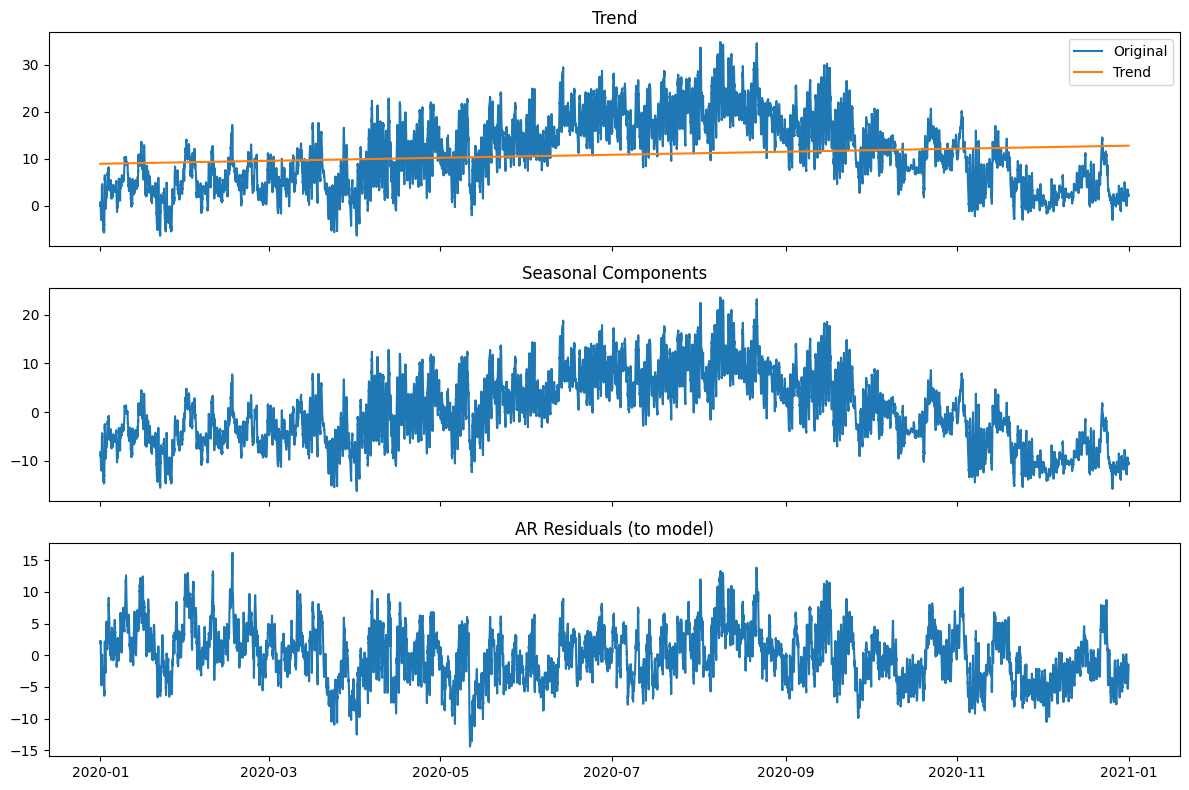

In [5]:
# %% 4. Component Extraction & Visualization
# ------------------------------------------

# 4.1 Reconstruct trend (already in 'trend')

# 4.2 Seasonal components via sinusoidal regression
X_season = np.column_stack([
    np.sin(2 * np.pi * t_idx / T_season1),
    np.cos(2 * np.pi * t_idx / T_season1),
    np.sin(2 * np.pi * t_idx / T_season2),
    np.cos(2 * np.pi * t_idx / T_season2)
])
# Fit amplitudes
alpha, *_ = np.linalg.lstsq(X_season, y - trend, rcond=None)
# Daily/primary seasonal
A1 = np.hypot(alpha[0], alpha[1]); phi1 = np.arctan2(alpha[1], alpha[0])
# Secondary seasonal
A2 = np.hypot(alpha[2], alpha[3]); phi2 = np.arctan2(alpha[3], alpha[2])
season1 = A1 * np.sin(2 * np.pi * t_idx / T_season1 + phi1)
season2 = A2 * np.sin(2 * np.pi * t_idx / T_season2 + phi2)
seasonal = season1 + season2

# 4.3 Residuals after removing trend + seasonality
residuals = y - trend - seasonal

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax[0].plot(df.index, y, label='Original')
ax[0].plot(df.index, trend, label='Trend')
ax[0].legend(); ax[0].set_title('Trend')
ax[1].plot(df.index, residuals + seasonal, label='Seasonal')
ax[1].set_title('Seasonal Components')
ax[2].plot(df.index, residuals, label='Residuals')
ax[2].set_title('AR Residuals (to model)')
plt.tight_layout(); plt.show()

In [6]:
# %% 5. Synthetic Data Generation using SDG
# ------------------------------------------

# 5.1 Fit AR(p) to residuals
ar_model = AutoReg(residuals, lags=p, old_names=False).fit()
phi_params = ar_model.params[1:]
sigma = np.sqrt(ar_model.sigma2)
print(f"AR coefficients: {phi_params} Innovation std: {sigma:.4f}")

AR coefficients: [ 1.45828739 -0.57741306  0.21634511 -0.08441362  0.03396533 -0.02015131
  0.0063269  -0.01379433 -0.00871796  0.01183784 -0.00995738  0.00286796
 -0.01884068  0.00554902  0.00475044 -0.00386016  0.00284075 -0.00741365
 -0.00275199 -0.01106845  0.01505826 -0.01281049  0.01956166 -0.02025139
  0.01992643 -0.02492462  0.01680188 -0.01154885  0.0060197   0.00440284] Innovation std: 0.2016


In [7]:
# 5.2 Generate synthetic residuals
epsilon = np.random.normal(0, sigma, size=nt)
syn_resid = np.zeros(nt)
syn_resid[:p] = residuals[:p]
for i in range(p, nt):
    syn_resid[i] = phi_params @ syn_resid[i-p:i][::-1] + epsilon[i]

In [8]:
# 5.3 Compose synthetic series
synthetic = trend + seasonal + syn_resid

series_real = pd.Series(y, index=df.index, name='Real')
series_syn = pd.Series(synthetic, index=df.index, name='Synthetic')

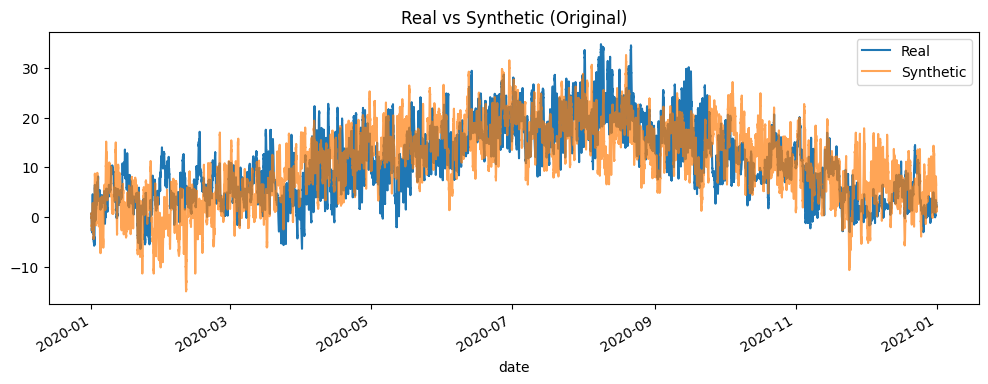

In [ ]:
#5.4 Visualize synthetic vs real

# Original
plt.figure(figsize=(12, 4))
series_real.plot(label='Real')
series_syn.plot(label='Synthetic', alpha=0.7)
plt.legend(); plt.title('Real vs Synthetic (Original)'); plt.show()

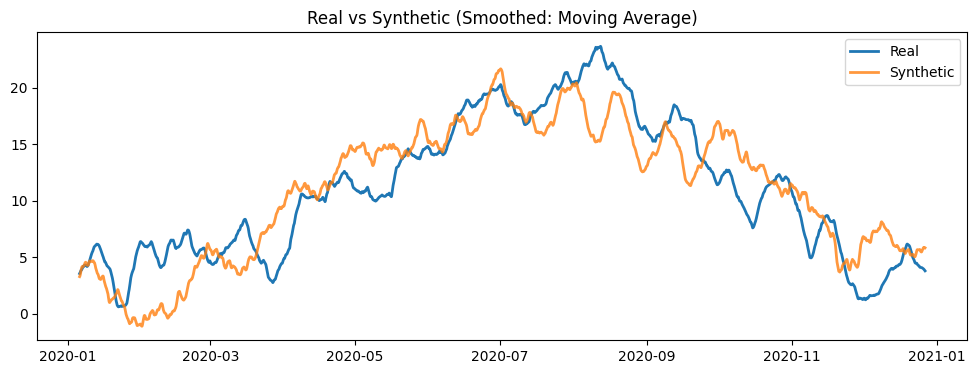

In [10]:
# Method 1: Moving average
# choose your window size
window = 144 * 10

# compute centered rolling means
real_smooth = series_real.rolling(window=window, center=True).mean()
syn_smooth  = series_syn.rolling(window=window, center=True).mean()

plt.figure(figsize=(12,4))
# plt.plot(series_real.index, real_smooth, label='Real ({}‑day MA)'.format(int(window/144)), linewidth=2)
plt.plot(series_real.index, real_smooth, label='Real', linewidth=2)
# plt.plot(series_syn.index,  syn_smooth,  label='Synthetic ({}‑day MA)'.format(int(window/144)), linewidth=2, alpha=0.8)
plt.plot(series_syn.index,  syn_smooth,  label='Synthetic', linewidth=2, alpha=0.8)
plt.legend()
plt.title('Real vs Synthetic (Smoothed: Moving Average)')
plt.show()

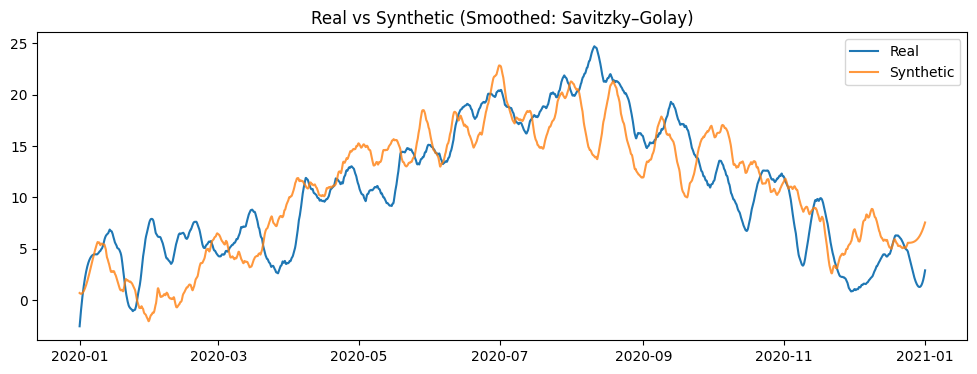

In [11]:
# Method 2: Savitzky-Golay filter
from scipy.signal import savgol_filter

# window_length must be odd, polyorder < window_length
window_length = 144 * 15
polyorder     = 3

real_smooth = savgol_filter(series_real.values, window_length, polyorder)
syn_smooth  = savgol_filter(series_syn.values,  window_length, polyorder)

plt.figure(figsize=(12,4))
plt.plot(df.index, real_smooth, label='Real')
plt.plot(df.index, syn_smooth,  label='Synthetic', alpha=0.8)
plt.legend()
plt.title('Real vs Synthetic (Smoothed: Savitzky–Golay)')
plt.show()

In [ ]:
# %% 6. Statistical & Structural Testing
# ------------------------------------------

metrics = {}

# 6.1 Marginal statistics: mean, variance
df_stat = pd.DataFrame({
    'Real': [series_real.mean(), series_real.var()],
    'Synthetic': [series_syn.mean(), series_syn.var()]
}, index=['Mean', 'Variance'])
# print(df_stat)
metrics['Mean Diff'] = series_real.mean() - series_syn.mean()
metrics['Var Diff'] = series_real.var() - series_syn.var()
print()

# 6.2 ACF distance
def acf_l2(x, y, nlags=30):
    return np.sum((acf(x, nlags=nlags, fft=True) - acf(y, nlags=nlags, fft=True))**2)
metrics['ACF L2'] = acf_l2(series_real, series_syn)
print(f"ACF L2 distance: {metrics['ACF L2']:.4f}")

# 6.3 Normalized PSD distance
def psd_l2(x, y):
    fx, Px = periodogram(x)
    fy, Py = periodogram(y)
    return np.sum((Px - Py)**2) / np.sum(Px**2)
metrics['Normalized PSD L2'] = psd_l2(series_real, series_syn)
print(f"Normalized PSD L2 distance: {metrics['Normalized PSD L2']:.4f}")

# 6.4 KS test
ksd, ksp = ks_2samp(series_real, series_syn)
metrics['KS Stat'] = ksd; metrics['KS p'] = ksp
print(f"KS test statistic: {ksd:.4f}, p-value: {ksp:.4f}")

# 6.5 Classification distinguishability
w = 50
X, yl = [], []
for i in range(nt-w):
    X.append(y[i:i+w]);    yl.append(0)
    X.append(synthetic[i:i+w]); yl.append(1)
X = np.array(X).reshape(-1, w)
yl = np.array(yl)
Xtr, Xte, ytr, yte = train_test_split(X, yl, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(Xtr, ytr)
metrics['Clf Acc'] = accuracy_score(yte, clf.predict(Xte))
print(f"Classification accuracy: {metrics['Clf Acc']:.4f}")


ACF L2 distance: 0.0000
Normalized PSD L2 distance: 0.0082
KS test statistic: 0.0420, p-value: 0.0000
Classification accuracy: 0.8915


In [13]:
# %% 7. Metrics Summary & Visualization
# ------------------------------------------

results = pd.Series(metrics).to_frame('Value')
print(results)
# results.plot(kind='bar', figsize=(10, 4), legend=False)
# plt.title('SDG vs Real Metrics'); plt.tight_layout(); plt.show()

                          Value
Mean Diff          3.611215e-03
Var Diff           7.782840e-01
ACF L2             3.701348e-06
Normalized PSD L2  8.164167e-03
KS Stat            4.195764e-02
KS p               9.652869e-41
Clf Acc            8.915411e-01
